# Can a Simple Strategy Beat Buy & Hold? A Bayesian Optimization Study on the 10 Most Active Stocks

This notebook explores the effectiveness of a double moving average crossover strategy compared to a Buy & Hold approach across the 10 most actively traded stocks on the market. Using Bayesian Optimization, we fine-tune the short and long moving average windows for each stock to maximize final portfolio value. The strategy is evaluated on out-of-sample test data, and performance metrics such as return, number of trades, and equity curves are visualized. This comparative study reveals where the strategy outperforms, where it lags, and offers visual insights for data-driven storytelling.

## Import Libraries

In [36]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import time
import numpy as np
import calendar

plt.style.use("dark_background")

tickers = ["LCID", "NVDA", "INTC", "F", "TSLA", "HOOD", "WULF", "CIFR", "SOFI", "IREN"]
start_date = "2020-01-01"
end_date = "2025-06-30"
train_cutoff_date = "2023-12-31"
initial_capital = 10

results = []


## Strategy Function

In [37]:
def backtest_strategy_double_ma(data, short_window, long_window, initial_capital):
    df = data.copy()
    df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()
    df['Signal'] = 0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Signal'] = 1
    df['Position'] = df['Signal'].shift(1)
    df['Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Position'] * df['Return']
    df['Equity Curve'] = (1 + df['Strategy Return']).cumprod() * initial_capital
    final_value = df['Equity Curve'].iloc[-1]
    num_trades = df['Position'].diff().abs().sum()
    return final_value, num_trades, df

## Run Strategy for all Tickers

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for LCID...


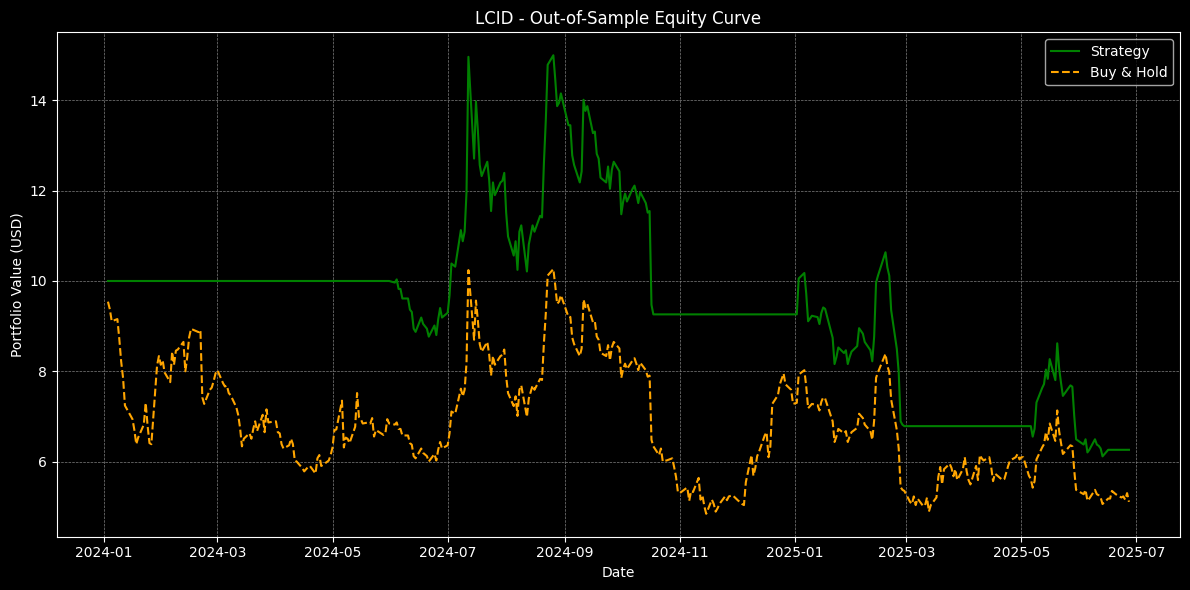

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for NVDA...


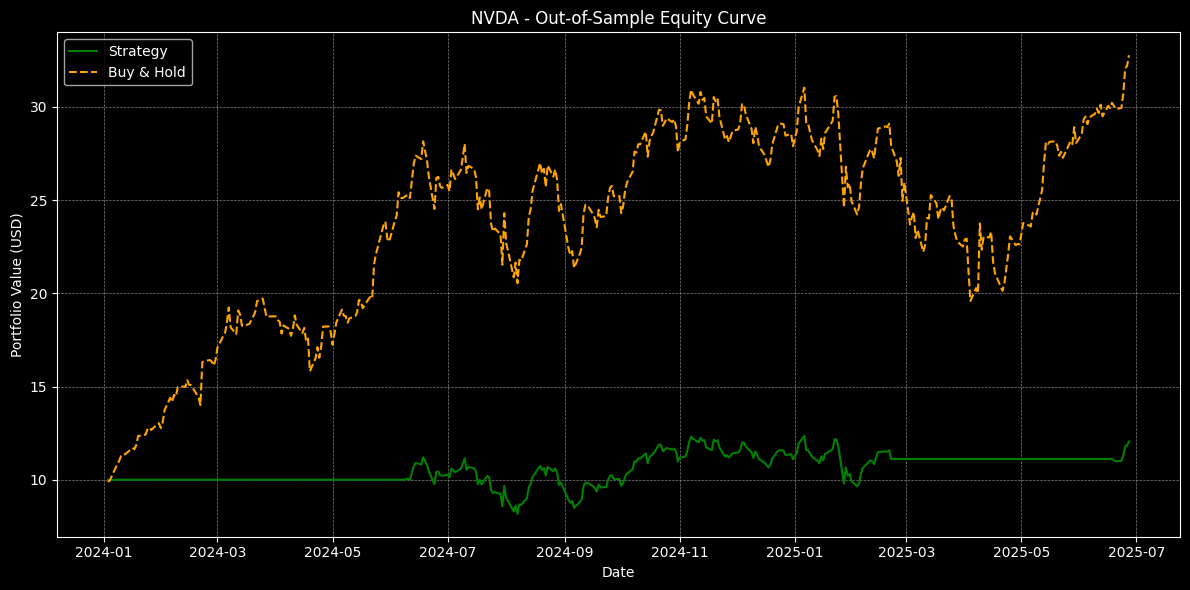

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


Running for INTC...


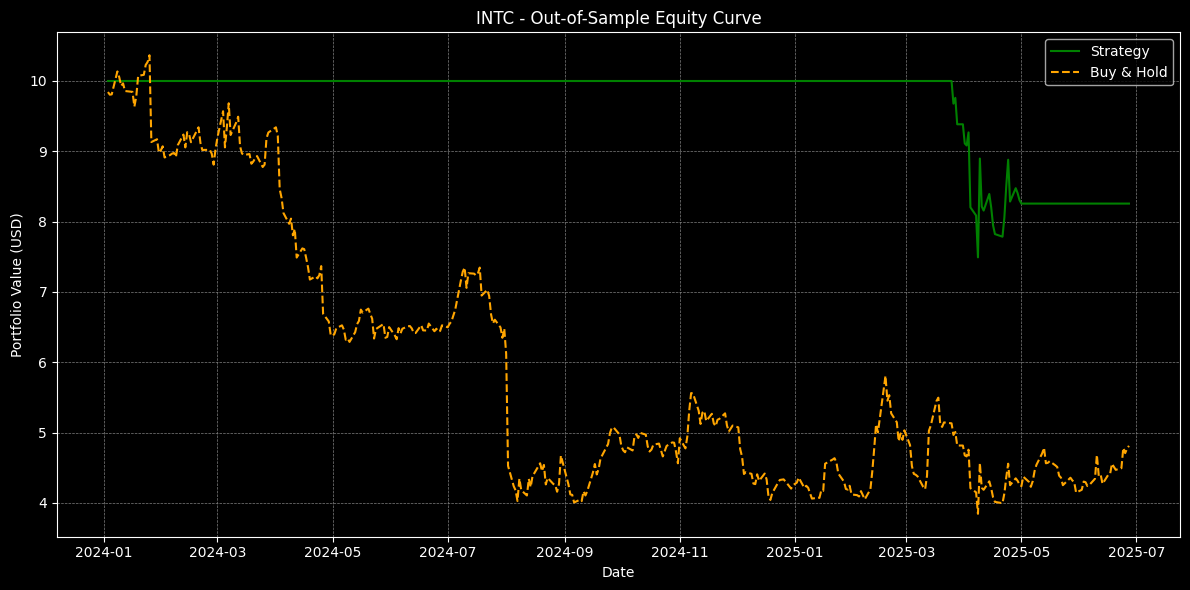

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for F...


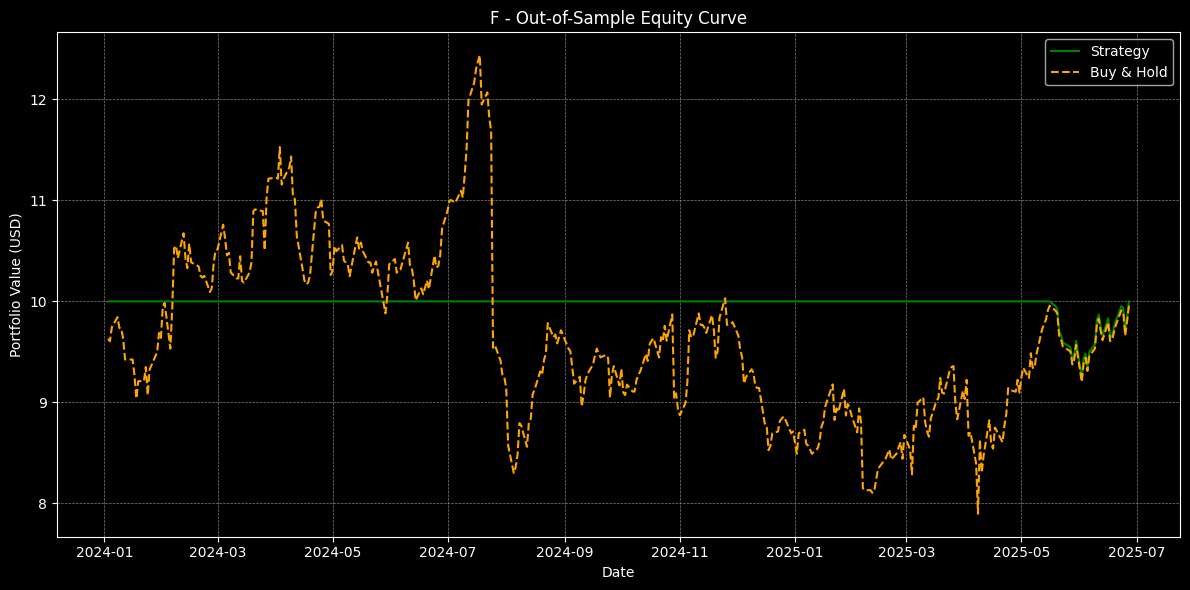

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for TSLA...


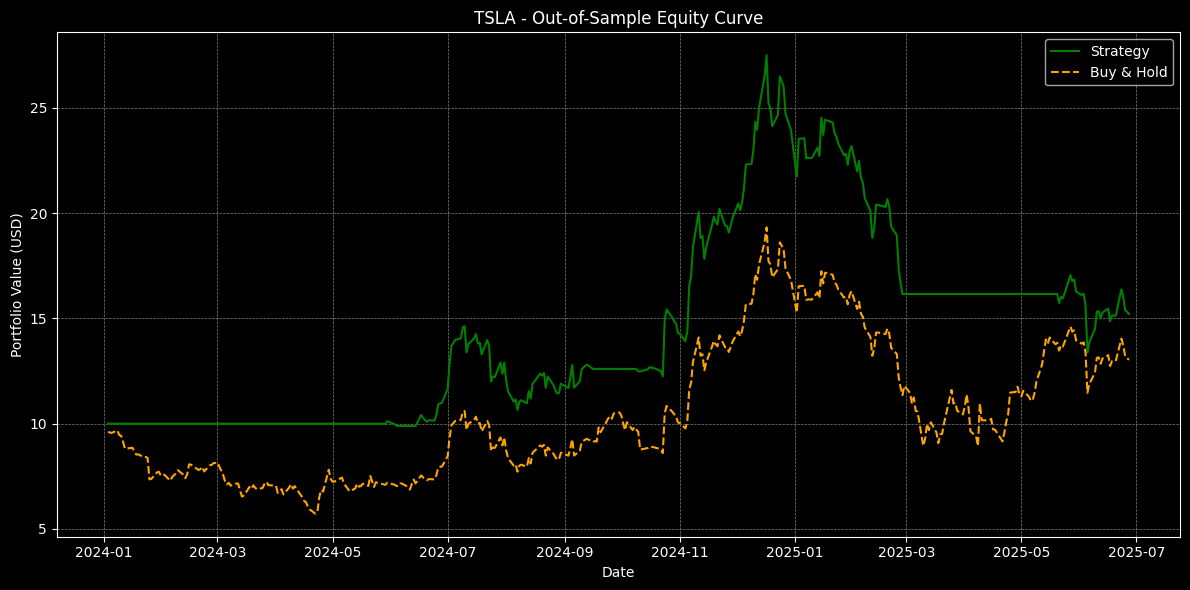

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for HOOD...


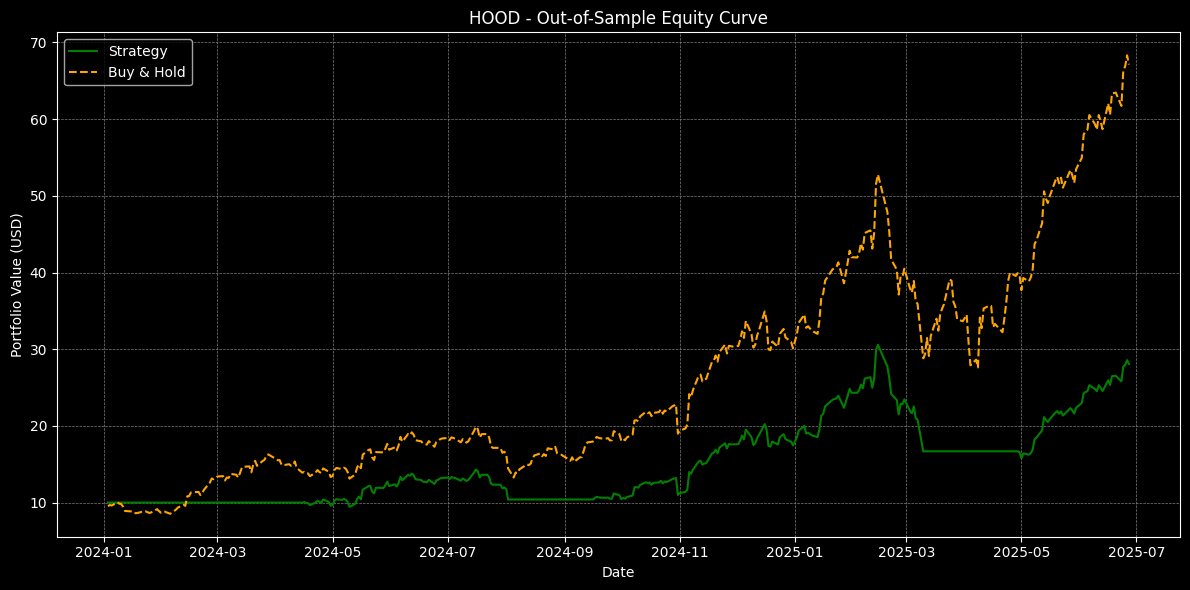

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for WULF...


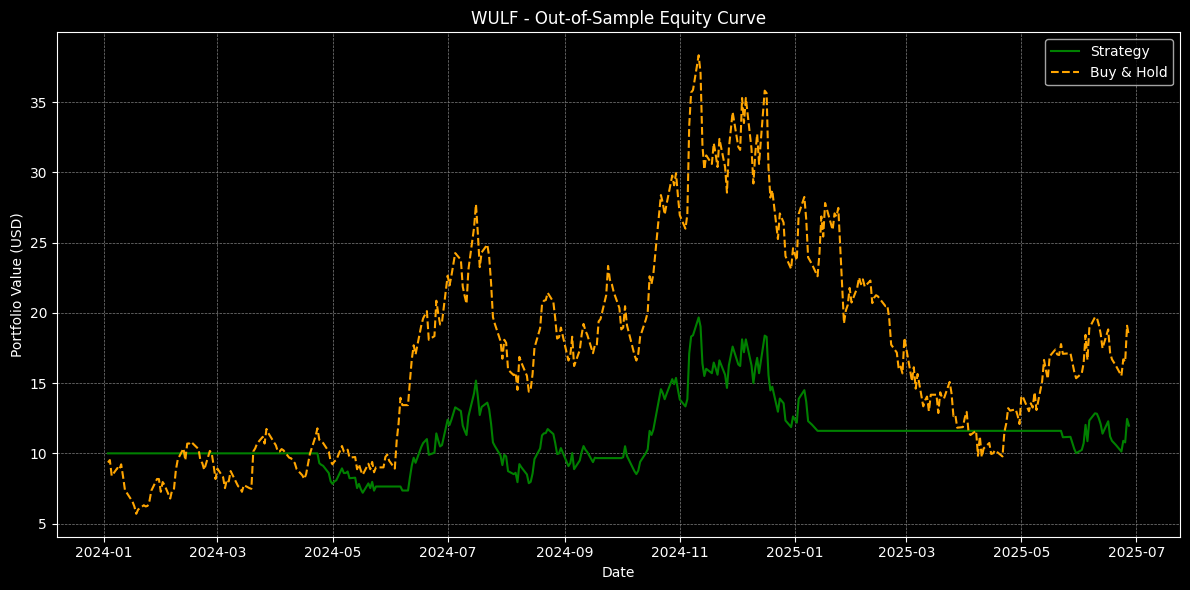

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for CIFR...


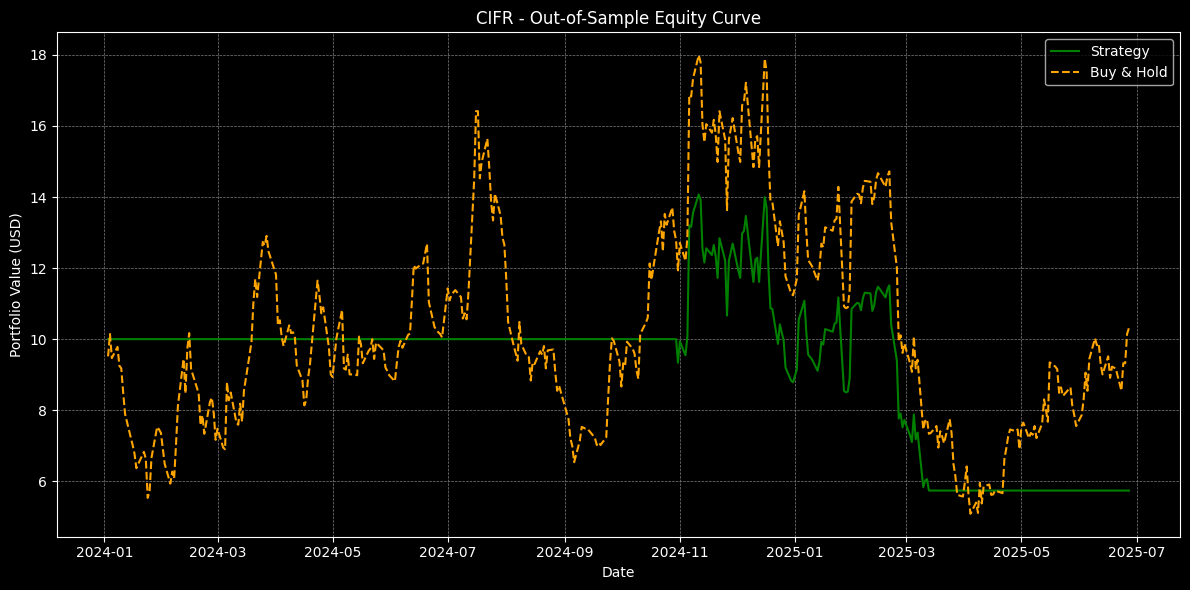

C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed

Running for SOFI...


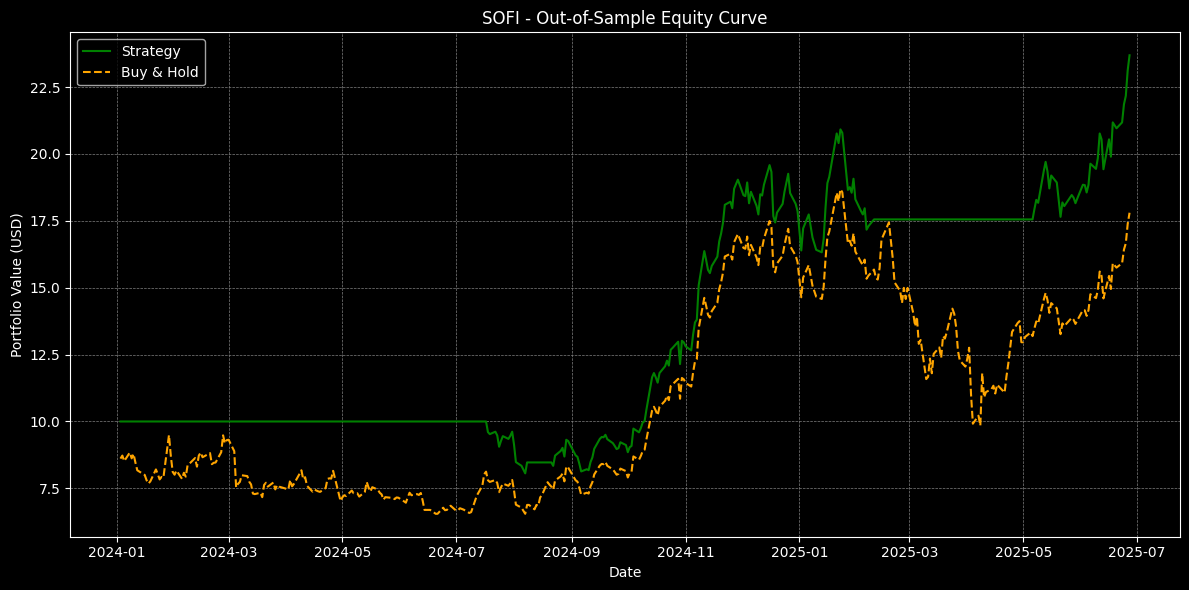

Running for IREN...


C:\Users\Brian\AppData\Local\Temp\ipykernel_5112\2820759038.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


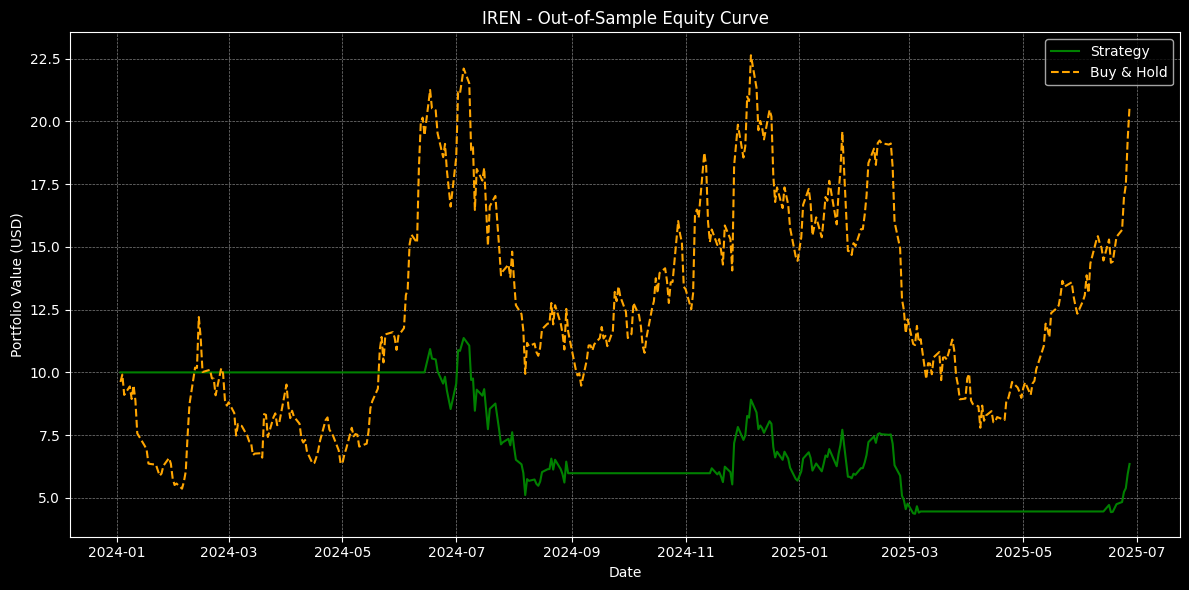

In [ ]:
for symbol in tickers:
    print(f"Running for {symbol}...")
    df = yf.download(symbol, start=start_date, end=end_date)[['Close']]

    df_train = df.loc[start_date:train_cutoff_date].copy()
    df_test = df.loc[train_cutoff_date:end_date].copy()

    def backtest_bo(short_window, long_window):
        short_window = int(round(short_window))
        long_window = int(round(long_window))
        if short_window >= long_window:
            return -1e10
        final_value, _, _ = backtest_strategy_double_ma(df_train, short_window, long_window, initial_capital)
        return final_value

    pbounds = {'short_window': (5, 50), 'long_window': (55, 200)}
    optimizer = BayesianOptimization(f=backtest_bo, pbounds=pbounds, random_state=42, verbose=0)
    optimizer.maximize(init_points=5, n_iter=45)

    best_params = optimizer.max['params']
    best_short_window = int(round(best_params['short_window']))
    best_long_window = int(round(best_params['long_window']))

    _, _, df_test_result = backtest_strategy_double_ma(df_test, best_short_window, best_long_window, initial_capital)
    df_test_result['Buy & Hold'] = (1 + df_test_result['Return']).cumprod() * initial_capital

    final_strategy_value = df_test_result['Equity Curve'].iloc[-1]
    final_bh_value = df_test_result['Buy & Hold'].iloc[-1]
    strategy_return_pct = ((final_strategy_value / initial_capital) - 1) * 100
    bh_return_pct = ((final_bh_value / initial_capital) - 1) * 100
    num_trades = df_test_result['Position'].diff().abs().sum()

    results.append({
        "Symbol": symbol,
        "Short Window": best_short_window,
        "Long Window": best_long_window,
        "Strategy Final Value": final_strategy_value,
        "Buy & Hold Final Value": final_bh_value,
        "Strategy Return (%)": strategy_return_pct,
        "Buy & Hold Return (%)": bh_return_pct,
        "Trades": int(num_trades)
    })
    
    # Print the results for the current symbol
    print(f"{symbol} - Best Short Window: {best_short_window}, Best Long Window: {best_long_window}")
    print(f"{symbol} - Strategy Final Value: ${final_strategy_value:.2f}, Buy & Hold Final Value: ${final_bh_value:.2f}")
    print(f"{symbol} - Strategy Return: {strategy_return_pct:.2f}%, Buy & Hold Return: {bh_return_pct:.2f}%")
    print(f"{symbol} - Number of Trades: {int(num_trades)}\n")

    # Plot equity curve comparison
    plt.figure(figsize=(12, 6))
    plt.plot(df_test_result['Equity Curve'], label='Strategy', color='green')
    plt.plot(df_test_result['Buy & Hold'], label='Buy & Hold', linestyle='--', color='orange')
    plt.title(f"{symbol} - Out-of-Sample Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"{symbol}_equity_curve.png", dpi=300)
    plt.show()

## Results Table

In [52]:
results_df = pd.DataFrame(results)
results_df = results_df.set_index("Symbol")
results_df = results_df.sort_values("Strategy Return (%)", ascending=False)

# Format numeric columns for nicer display
results_df["Strategy Return (%)"] = results_df["Strategy Return (%)"].map(lambda x: f"{x:.2f}")
results_df["Buy & Hold Return (%)"] = results_df["Buy & Hold Return (%)"].map(lambda x: f"{x:.2f}")
results_df["Strategy Final Value"] = results_df["Strategy Final Value"].map(lambda x: f"{x:.2f}")
results_df["Buy & Hold Final Value"] = results_df["Buy & Hold Final Value"].map(lambda x: f"{x:.2f}")

results_df.to_csv("multi_ticker_strategy_comparison.csv")
results_df

,Short Window,Long Window,Strategy Final Value,Buy & Hold Final Value,Strategy Return (%),Buy & Hold Return (%),Trades
Symbol,,,,,,,
HOOD,5,72,28.06,67.12,180.63,571.22,5
SOFI,9,61,23.69,17.80,136.90,78.03,5
TSLA,50,55,15.20,13.03,52.05,30.28,9
NVDA,50,109,12.05,32.76,20.50,227.65,3
WULF,17,78,11.97,18.35,19.71,83.48,7
F,44,171,10.00,9.96,0.00,-0.43,1
INTC,50,145,8.26,4.81,-17.44,-51.90,2
IREN,26,115,6.35,20.59,-36.48,105.88,5
LCID,32,55,6.26,5.11,-37.39,-48.92,6


## Visualization – Strategy vs Buy & Hold Across Tickers

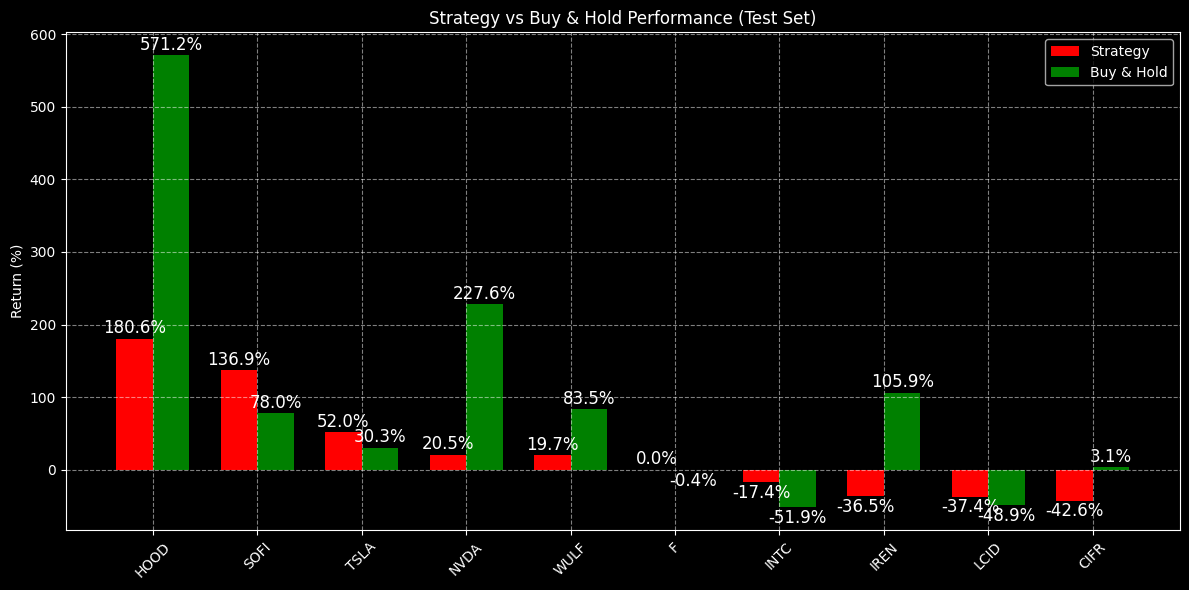

In [51]:
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

bars1 = plt.bar(x - width/2, results_df["Strategy Return (%)"], width, label="Strategy", color='red')
bars2 = plt.bar(x + width/2, results_df["Buy & Hold Return (%)"], width, label="Buy & Hold", color='green')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + np.sign(height)*2, f"{height:.1f}%", 
                 ha='center', va='bottom' if height >= 0 else 'top', fontsize=12)

plt.xticks(x, results_df.index, rotation=45)
plt.ylabel("Return (%)")
plt.title("Strategy vs Buy & Hold Performance (Test Set)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("comparison_bar_chart.png", dpi=300)
plt.show()